In [24]:
import csv
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib



In [37]:
def load_and_process_bedSVM(file_path, X, y, nn, meann, varr):
    # Define column headers and columns to use
    columns = ['chr', 'start', 'end', 'cn', 'mean_cov', 'len', 'pcn', 'is_pass', 'rep_len', 'rep_pct',
               'discard1', 'discard2', 'discard3', 'mean_bin', 'clip', 'poss', 'ref_all', 'alt_all', 'r_ct', 'alt_ct']
    columns_to_discard = ['pcn', 'is_pass', 'rep_len', 'r_ct', 'alt_ct', 'ref_all', 'alt_all', 'poss',
                          'discard1', 'discard2', 'discard3', 'end', 'mean_cov']
    use_cols = [col for col in columns if col not in columns_to_discard]

    # Load the data
    df1 = pd.read_csv(file_path, sep='\t', header=None, names=columns, usecols=use_cols)

    # Group and aggregate data
    grouped_df = df1.groupby(['chr', 'len', 'cn']).agg(custom_agg).reset_index()

    # Add mean and variance columns
    grouped_df['meann'] = int(meann)
    grouped_df['varr'] = int(varr)


    # Encode 'chr' column
    label_encoder = LabelEncoder()
    grouped_df['chr'] = label_encoder.fit_transform(grouped_df['chr'])

    new_columns = {}

    for col in ['mean_bin', 'clip']:
        # Create a DataFrame from the expanded lists
        expanded_data = [x[:max_len] + [0] * (max_len - len(x)) for x in grouped_df[col]]
        new_columns[col] = pd.DataFrame(expanded_data, index=grouped_df.index)
        new_columns[col].columns = [f'{col}_{i}' for i in range(max_len)]

    # Concatenate all new columns with the original DataFrame
    grouped_df = pd.concat([grouped_df] + list(new_columns.values()), axis=1)
    print(grouped_df['cn'].unique())
    
    # Drop original and unnecessary columns
    
   # if nn != 0:
   #     grouped_df = grouped_df[(grouped_df['cn'] > 3) & (grouped_df['cn'] < 11)]

   # grouped_df = grouped_df[(grouped_df['rep_pct'] < 0.8)]    
    print(grouped_df['cn'].unique())

    
    grouped_df.drop(['mean_bin', 'clip', 'cn','rep_pct'], axis=1, inplace=True)
    
    # Optionally sample a subset of data
   # if nn == 0:
    #    grouped_df = grouped_df.sample(frac=0.1, random_state=42)

    # Convert DataFrame to NumPy array
    df_array = np.array(grouped_df.values, dtype=float)
    new_y = np.full(df_array.shape[0], nn)

    # Concatenate arrays
    X = np.concatenate((X, df_array), axis=0) if X is not None else df_array
    y = np.concatenate((y, new_y), axis=0) if y is not None else new_y

    return X, y

In [10]:
def load_and_process_bedSVM_multi(file_path, X, y, nn, meann, varr):
    # Define column headers and columns to use
    columns = ['chr', 'start', 'end', 'cn', 'mean_cov', 'len', 'pcn', 'is_pass', 'rep_len', 'rep_pct',
               'discard1', 'discard2', 'discard3', 'mean_bin', 'clip', 'poss', 'ref_all', 'alt_all', 'r_ct', 'alt_ct']
    columns_to_discard = ['pcn', 'is_pass', 'rep_len', 'r_ct', 'alt_ct', 'ref_all', 'alt_all', 'poss',
                          'discard1', 'discard2', 'discard3', 'end', 'mean_cov']
    use_cols = [col for col in columns if col not in columns_to_discard]

    # Load the data
    df1 = pd.read_csv(file_path, sep='\t', header=None, names=columns, usecols=use_cols)

    # Group and aggregate data
    grouped_df = df1.groupby(['chr', 'len', 'cn']).agg(custom_agg).reset_index()

    # Add mean and variance columns
    grouped_df['meann'] = int(meann)
    grouped_df['varr'] = int(varr)


    # Encode 'chr' column
    label_encoder = LabelEncoder()
    grouped_df['chr'] = label_encoder.fit_transform(grouped_df['chr'])

    new_columns = {}

    for col in ['mean_bin', 'clip']:
        # Create a DataFrame from the expanded lists
        expanded_data = [x[:max_len] + [0] * (max_len - len(x)) for x in grouped_df[col]]
        new_columns[col] = pd.DataFrame(expanded_data, index=grouped_df.index)
        new_columns[col].columns = [f'{col}_{i}' for i in range(max_len)]

    # Concatenate all new columns with the original DataFrame
    grouped_df = pd.concat([grouped_df] + list(new_columns.values()), axis=1)
    print(grouped_df['cn'].unique())
    # Drop original and unnecessary columns
    
    if nn != 0:
        grouped_df = grouped_df[(grouped_df['cn'] > 3) & (grouped_df['cn'] < 11)]

    grouped_df = grouped_df[(grouped_df['rep_pct'] < 0.8)]
    
    print(grouped_df['cn'].unique())

    new_y = np.array(grouped_df['cn'])

    grouped_df.drop(['mean_bin', 'clip', 'cn'], axis=1, inplace=True)
    
    # Optionally sample a subset of data
   # if nn == 0:
    #    grouped_df = grouped_df.sample(frac=0.1, random_state=42)

    # Convert DataFrame to NumPy array
    df_array = np.array(grouped_df.values, dtype=float)

    # Concatenate arrays
    X = np.concatenate((X, df_array), axis=0) if X is not None else df_array
    y = np.concatenate((y, new_y), axis=0) if y is not None else new_y

    return X, y

In [38]:
#slop of 500 was used upstream
def custom_agg(series):
    if series.name == 'start':
        return series.iloc[0] + 500
    elif series.name == 'end':
        return series.iloc[-1] - 500
 #   elif series.nunique() == 1:
 #       return series.iloc[0]
    else:
        return series.tolist()

In [27]:
#lb, ub of len
min_len = 50
max_len = 2000


samples = {}
c=0
with open("/Users/red/Downloads/drive-download-20231213T041531Z-001/test_genomes_cov.txt") as s:
  for line in s.readlines():
    if c<5:
      line=line.rstrip()
      line=line.split("\t")
      samples[line[0]] = [line[1], line[2]]
      c+=1
print(samples)

{'HG00621': ['40', '136'], 'HG00673': ['40', '130'], 'HG00733': ['34', '67'], 'HG00735': ['43', '129'], 'HG00741': ['38', '117']}


In [39]:

X, y = None, None
X_t, y_t = None, None

c = len(samples)

l=1
for sample,v in samples.items():
    print(sample)
    
    filepath1 = f"/Users/red/Downloads/drive-download-20231213T041531Z-001/{sample}.copy0_COMB.bed"
    filepath0 = f"/Users/red/Downloads/drive-download-20231213T041531Z-001/{sample}.neutral0_COMB.bed"
   
    if c==l:
        X_t, y_t = load_and_process_bedSVM(filepath0, X, y, 0, v[0], v[1])
        X_t, y_t = load_and_process_bedSVM(filepath1, X, y, 1, v[0], v[1])
    else:
        X, y = load_and_process_bedSVM(filepath0, X, y, 0, v[0], v[1])
        X, y = load_and_process_bedSVM(filepath1, X, y, 1, v[0], v[1])
    l+=1



HG00621
[2]
[2]
[ 1  3  0  4  5  7  6  8  9 10 14 13 23]
[ 1  3  0  4  5  7  6  8  9 10 14 13 23]
HG00673
[2]
[2]
[ 1  3  5  0  4  6  7  9  8 13 16 25]
[ 1  3  5  0  4  6  7  9  8 13 16 25]
HG00733
[2]
[2]
[ 3  5  1  4  0  7  6  9  8 18 12 10 11 13 14 64]
[ 3  5  1  4  0  7  6  9  8 18 12 10 11 13 14 64]
HG00735
[2]
[2]
[ 1  4  3  5  0  6  7  9  8 15]
[ 1  4  3  5  0  6  7  9  8 15]
HG00741
[2]
[2]
[ 1  3  5  4  0  6  7 10  8 15 14]
[ 1  3  5  4  0  6  7 10  8 15 14]


In [47]:
# Save X and y to a file
joblib.dump(X, 'orig_X.joblib')
joblib.dump(y, 'orig_y.joblib')
joblib.dump(X_t, 'orig_X_t.joblib')
joblib.dump(y_t, 'orig_y_t.joblib')

['orig_y_t.joblib']

In [28]:
X = joblib.load('X.joblib')
y = joblib.load('y.joblib')
X_t = joblib.load('X_t.joblib')
y_t = joblib.load('y_t.joblib')

In [40]:
X[:9]

array([[0.0000e+00, 5.1000e+03, 3.0269e+06, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 5.2000e+03, 1.5405e+06, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 5.3000e+03, 7.0930e+05, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [0.0000e+00, 5.7000e+03, 2.5894e+06, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 5.8000e+03, 2.7935e+06, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 5.9000e+03, 1.0389e+07, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [11]:

X, y = None, None
X_t, y_t = None, None

c = len(samples)

l=1
for sample,v in samples.items():
    print(sample)
    
    filepath1 = f"/Users/red/Downloads/drive-download-20231213T041531Z-001/{sample}.copy0_COMB.bed"
    filepath0 = f"/Users/red/Downloads/drive-download-20231213T041531Z-001/{sample}.neutral0_COMB.bed"
   
    if c==l:
        X_t, y_t = load_and_process_bedSVM_multi(filepath0, X, y, 0, v[0], v[1])
        X_t, y_t = load_and_process_bedSVM_multi(filepath1, X, y, 1, v[0], v[1])
    else:
        X, y = load_and_process_bedSVM_multi(filepath0, X, y, 0, v[0], v[1])
        X, y = load_and_process_bedSVM_multi(filepath1, X, y, 1, v[0], v[1])
    l+=1



HG00621
[2]
[2]
[ 1  3  0  4  5  7  6  8  9 10 14 13 23]
[ 4  5  7  6  8  9 10]
HG00673
[2]
[2]
[ 1  3  5  0  4  6  7  9  8 13 16 25]
[5 4 6 7 9 8]
HG00733
[2]
[2]
[ 3  5  1  4  0  7  6  9  8 18 12 10 11 13 14 64]
[ 5  4  7  6  9 10  8]
HG00735
[2]
[2]
[ 1  4  3  5  0  6  7  9  8 15]
[4 5 6 7 9 8]
HG00741
[2]
[2]
[ 1  3  5  4  0  6  7 10  8 15 14]
[ 5  4  6  7 10  8]


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [41]:
#create balanced independent set

data = pd.DataFrame(X_t)
data['label'] = y_t
# Separate the data by class
class_0 = data[data['label'] == 0]
class_1 = data[data['label'] == 1]

n_samples = min(len(class_0), len(class_1))

# Sample from each class
class_0_sample = class_0.sample(n=n_samples, random_state=42)
class_1_sample = class_1.sample(n=n_samples, random_state=42)

# Combine the samples to create a balanced test set
balanced_test_set = pd.concat([class_0_sample, class_1_sample])

# Split the balanced test set into features and labels
X_ind_test = balanced_test_set.drop('label', axis=1)
y_ind_test = balanced_test_set['label']

In [60]:

# Shuffle the dataset
shuffle_indices = np.random.permutation(len(X_ind_test))
X_ind_test = X_ind_test[shuffle_indices]
y_ind_test = y_ind_test[shuffle_indices]


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()

# Fit on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

X_ind_test_scaled = scaler.transform(np.array(X_ind_test))

In [43]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
# Initialize SVM classifier with a specific kernel, e.g., RBF
clf = SVC(kernel='rbf')
#clf = joblib.load('svm_model_checkpoint.pkl')

# Train the classifier
clf.fit(X_train_scaled, y_train)



SVC()

In [44]:
# Make predictions on the test set
y_pred = clf.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9896617740906191
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6699
           1       0.99      0.94      0.96      1136

    accuracy                           0.99      7835
   macro avg       0.99      0.97      0.98      7835
weighted avg       0.99      0.99      0.99      7835



In [46]:

joblib.dump(clf, 'orig_svm_model_checkpoint.pkl')
#clf = joblib.load('svm_model_checkpoint.pkl')


['orig_svm_model_checkpoint.pkl']

In [48]:

#joblib.dump(clf, 'svm_model_checkpoint.pkl')
#clf_multi = joblib.load('svm_model_checkpoint_multi.pkl')


In [52]:
# Make predictions on the ind test set
#y_ind_pred = clf.predict(X_ind_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_ind_test, y_ind_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_ind_test, y_ind_pred))

Accuracy: 0.9770996906971211
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8406
           1       1.00      0.96      0.98      8406

    accuracy                           0.98     16812
   macro avg       0.98      0.98      0.98     16812
weighted avg       0.98      0.98      0.98     16812



In [49]:
from sklearn.metrics import confusion_matrix


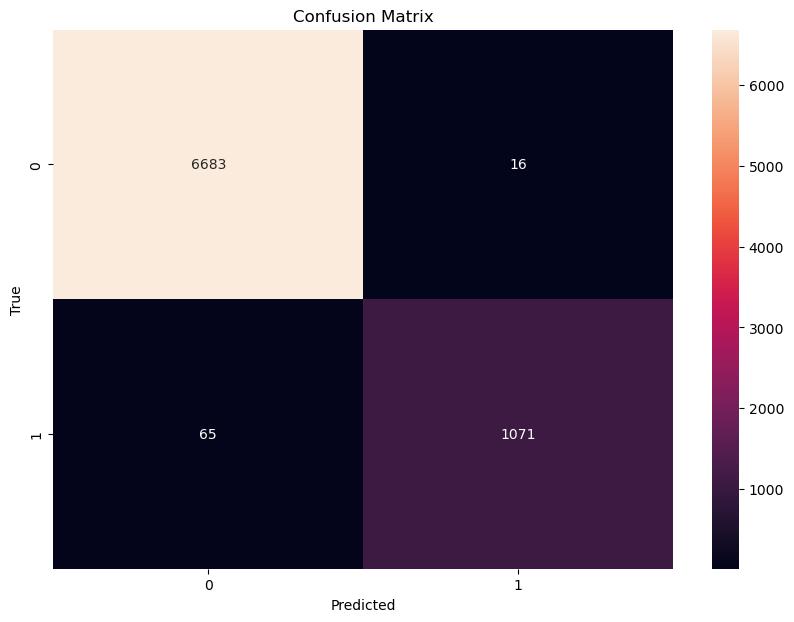

In [50]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

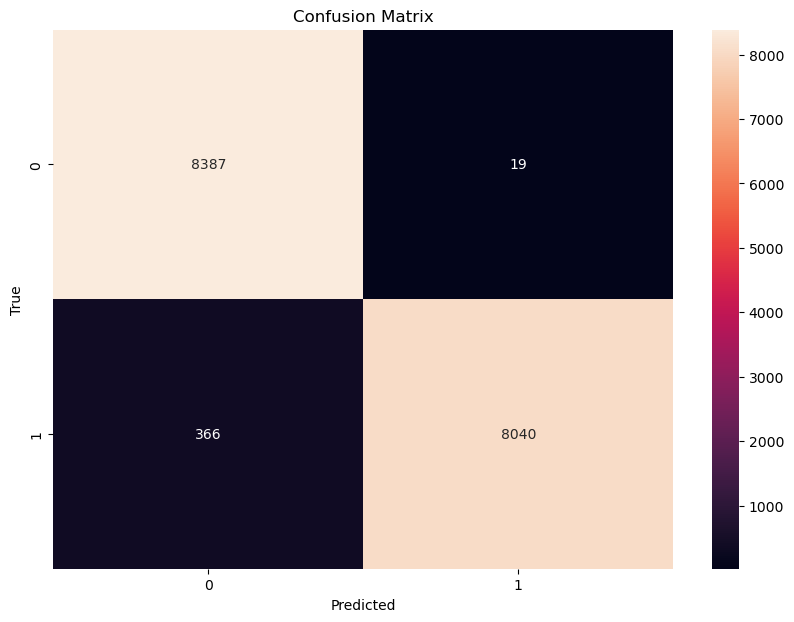

In [51]:
# Create the confusion matrix
cm1 = confusion_matrix(y_ind_test, y_ind_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm1, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [53]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [54]:
accuracies = []
precisions = []
recalls = []
f1_scores = []



for train_index, test_index in skf.split(X, y):
    X_trainSTR, X_testSTR = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit on training data
    X_train_scaled = scaler.fit_transform(X_trainSTR)

    X_test_scaled = scaler.transform(X_testSTR)
    
    # Fit the model
    clf.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_scaled)

    # Calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))


In [56]:
print(f'Average Accuracy: {np.mean(accuracies):.2f}')
print(f'Average Precision: {np.mean(precisions):.2f}')
print(f'Average Recall: {np.mean(recalls):.2f}')
print(f'Average F1 Score: {np.mean(f1_scores):.2f}')


Average Accuracy: 0.99
Average Precision: 0.99
Average Recall: 0.99
Average F1 Score: 0.99


In [8]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {'C': [1, 10], 'gamma': [0.1,0.01], 'kernel': ['rbf']}

# Grid search for best parameters
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

# Output best parameters and score
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   6.9s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   6.9s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   6.8s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   6.8s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   6.8s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   6.9s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   6.9s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   6.8s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   6.8s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   6.9s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   6.9s
[CV] END ........................C=10, gamma=0.1,

In [57]:
print(accuracies)

[0.988895979578813, 0.9886407147415444, 0.9920867900446714, 0.98851308232291, 0.98838396732193]


In [9]:
# Retrain with best parameters
best_clf = SVC(**grid.best_params_)
best_clf.fit(X_train, y_train)

# Re-evaluate
y_pred_best = best_clf.predict(X_test)
print(f"Accuracy with best parameters: {accuracy_score(y_test, y_pred_best)}")


Accuracy with best parameters: 0.5826446280991735


In [81]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


In [82]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

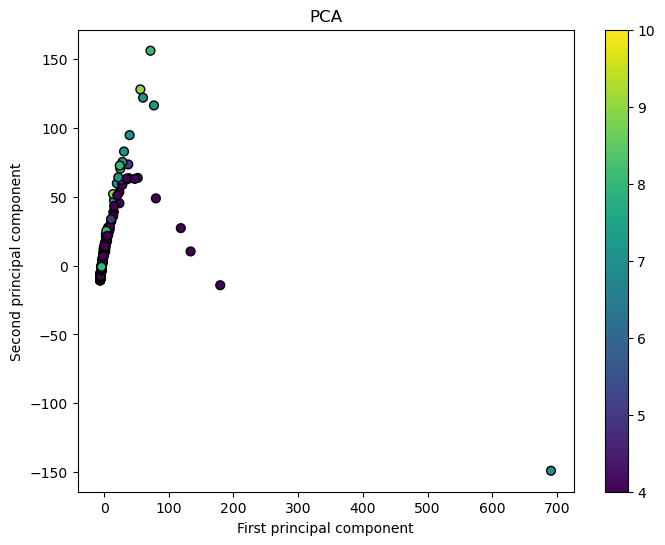

In [83]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
plt.title("PCA")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.colorbar()
plt.show()

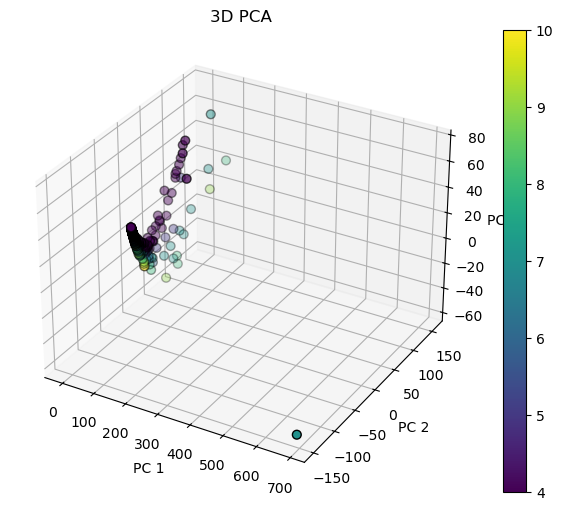

In [84]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', edgecolor='k', s=40)
ax.set_title("3D PCA")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
plt.colorbar(scatter)
plt.show()

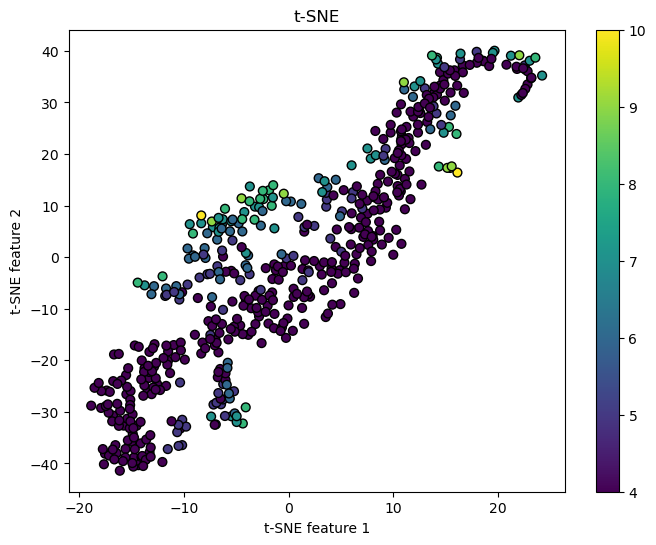

In [87]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
plt.title("t-SNE")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.colorbar()
plt.show()

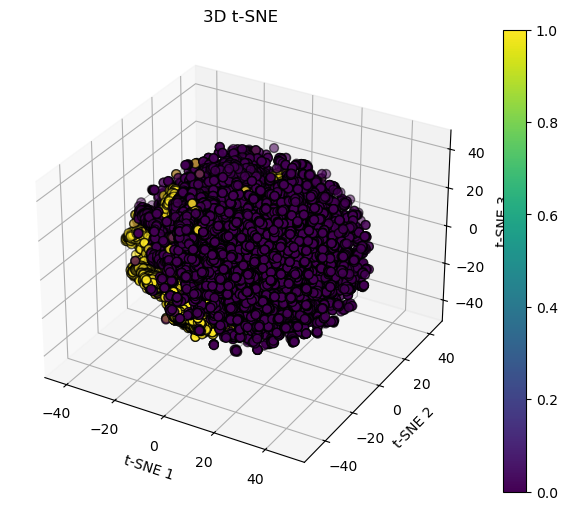

In [13]:
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, cmap='viridis', edgecolor='k', s=40)
ax.set_title("3D t-SNE")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.colorbar(scatter)
plt.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


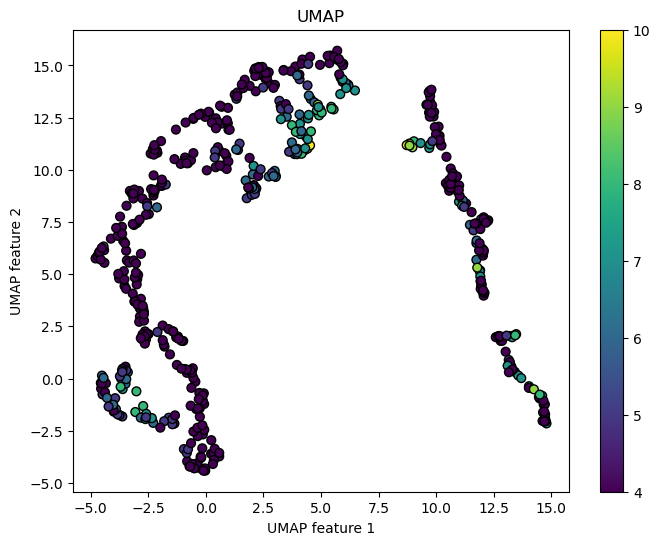

In [85]:
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
X_umap = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
plt.title("UMAP")
plt.xlabel("UMAP feature 1")
plt.ylabel("UMAP feature 2")
plt.colorbar()
plt.show()

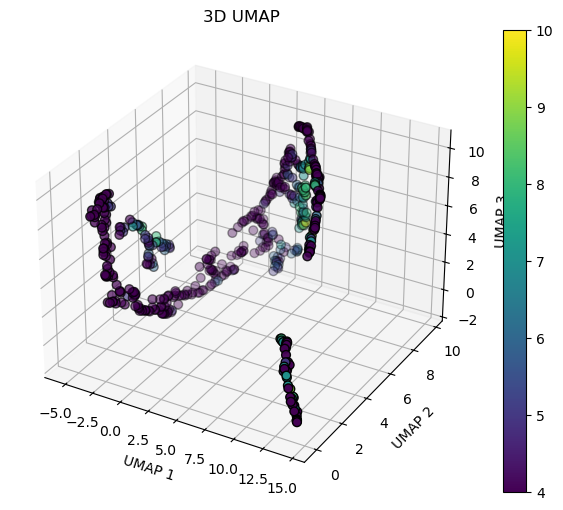

In [86]:
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=3)
X_umap = umap_model.fit_transform(X_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=y, cmap='viridis', edgecolor='k', s=40)
ax.set_title("3D UMAP")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
plt.colorbar(scatter)
plt.show()